In [1]:
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
routes = pd.read_csv('kaggle_data/routes.csv')
airlines = pd.read_csv('kaggle_data/airlines.csv')
airports = pd.read_csv("kaggle_data/airports.csv")

In [3]:
# GET AIRPORT COORD INFO
airports_us = airports[airports['Country'] == 'United States']
airport_coords = airports_us[['IATA', 'Latitude', 'Longitude']]
airport_coords = airport_coords.dropna()
airport_coords = airport_coords.set_index('IATA')

In [4]:
# 1. Select active U.S. airlines
airlines_key = airlines[["Airline ID", "Name", "IATA", "Country", "Active"]].copy()
airlines_key = airlines_key[
    (airlines_key["Country"] == "United States") & 
    (airlines_key["Active"] == "Y")
]

# 2. Filter to selected major airlines
major_airlines = [
    'Delta Air Lines', 'American Airlines', 'United Airlines',
    'Southwest Airlines', 'Spirit Airlines', 'Frontier Airlines', 'JetBlue Airways'
]
us_airlines_key = airlines_key[airlines_key['Name'].isin(major_airlines)][["Airline ID", "IATA", "Name"]].copy()

# 3. Standardize ID types
routes['Airline ID'] = routes['Airline ID'].astype(str)
us_airlines_key['Airline ID'] = us_airlines_key['Airline ID'].astype(str)

# 4. Get valid U.S. airport IATA codes
airports_us = airports[airports['Country'] == 'United States'].copy()
us_airport_codes = set(airports_us['IATA'].dropna().astype(str))

# 5. Filter routes by airline and both endpoints being U.S. airports
filtered_routes = routes[routes['Airline ID'].isin(us_airlines_key['Airline ID'])].copy()
filtered_routes = filtered_routes[
    filtered_routes['Source airport'].isin(us_airport_codes) &
    filtered_routes['Destination airport'].isin(us_airport_codes)
]

# 6. Add airline names
filtered_routes = filtered_routes.merge(us_airlines_key, on='Airline ID', how='left')

In [5]:
filtered_routes

,index,Airline,Airline ID,Source airport,Source airport ID,Destination airport,Destination airport ID,Codeshare,Stops,Equipment,IATA,Name
0,4655,AA,24,ABE,4355,CLT,3876,Y,0,CR9 CR7 CRJ,AA,American Airlines
1,4656,AA,24,ABE,4355,PHL,3752,NaN,0,DH3,AA,American Airlines
2,4657,AA,24,ABI,3718,DFW,3670,Y,0,ERD ER4 CRJ,AA,American Airlines
3,4658,AA,24,ABQ,4019,DFW,3670,NaN,0,M83 M80,AA,American Airlines
4,4659,AA,24,ABQ,4019,LAX,3484,Y,0,CR7 CRJ,AA,American Airlines
...,...,...,...,...,...,...,...,...,...,...,...,...
5763,64557,WN,4547,TUS,3636,DEN,3751,NaN,0,73W 733,WN,Southwest Airlines
5764,64558,WN,4547,TUS,3636,LAS,3877,NaN,0,73W 73C,WN,Southwest Airlines
5765,64559,WN,4547,TUS,3636,LAX,3484,NaN,0,73C 73W 733 73H,WN,Southwest Airlines
5766,64560,WN,4547,TUS,3636,MDW,3747,NaN,0,73H 73W,WN,Southwest Airlines


In [6]:
# MAKE GRAPHS
airline_graphs = {}
for airline in major_airlines:
    airline_data = filtered_routes[filtered_routes['Name'] == airline]
    
    G = nx.DiGraph()
    for _, row in airline_data.iterrows():
        source = row['Source airport']
        dest = row['Destination airport']
        G.add_edge(source, dest)
    
    airline_graphs[airline] = G

# summary
for airline, G in airline_graphs.items():
    print(f"{airline}: {G.number_of_nodes()} airports, {G.number_of_edges()} routes")

Delta Air Lines: 217 airports, 1327 routes
American Airlines: 216 airports, 1414 routes
United Airlines: 235 airports, 1303 routes
Southwest Airlines: 89 airports, 1126 routes
Spirit Airlines: 28 airports, 182 routes
Frontier Airlines: 72 airports, 178 routes
JetBlue Airways: 52 airports, 238 routes


In [7]:
def plot_airline_network_styled(G, title, airport_coords):
    import numpy as np
    from matplotlib.colors import LinearSegmentedColormap

    def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
        return LinearSegmentedColormap.from_list(
            f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
            cmap(np.linspace(minval, maxval, n))
        )

    fig, ax = plt.subplots(figsize=(16, 10))

    basemap = Basemap(
        projection='merc',
        llcrnrlon=-180, urcrnrlon=-65,
        llcrnrlat=17, urcrnrlat=72,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True,
        ax=ax
    )

    basemap.drawstates(color='#666666')
    basemap.fillcontinents(color='#BBBBBB', lake_color='white')
    basemap.drawmapboundary(fill_color='white')

    pos = {
        node: (airport_coords.loc[node]['Longitude'], airport_coords.loc[node]['Latitude'])
        for node in G.nodes if node in airport_coords.index
    }
    proj_pos = {node: basemap(*coord) for node, coord in pos.items()}

    degrees = dict(G.degree())
    node_degrees = np.array([degrees[node] for node in G.nodes if node in proj_pos])
    node_sizes = np.interp(node_degrees, (node_degrees.min(), node_degrees.max()), (20, 300))
    node_colors = node_degrees

    # Trim BuPu to avoid white
    safe_cmap = truncate_colormap(plt.cm.BuPu, 0.2, 1.0)

    # Draw edges
    nx.draw_networkx_edges(
        G, pos=proj_pos, ax=ax,
        edgelist=G.edges(),
        edge_color='#5F9EA0',
        alpha=0.25,
        width=0.6,
        arrows=False
    )

    # Draw nodes
    nx.draw_networkx_nodes(
        G, pos=proj_pos, ax=ax,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=safe_cmap,
        alpha=0.9
    )

    # Colorbar
    norm = plt.Normalize(vmin=node_colors.min(), vmax=node_colors.max())
    sm = plt.cm.ScalarMappable(cmap=safe_cmap, norm=norm)
    sm._A = []
    plt.colorbar(sm, ax=ax, shrink=0.5, label='Airport Degree')

    ax.set_title(title, fontsize=18)
    plt.tight_layout()
    plt.show()


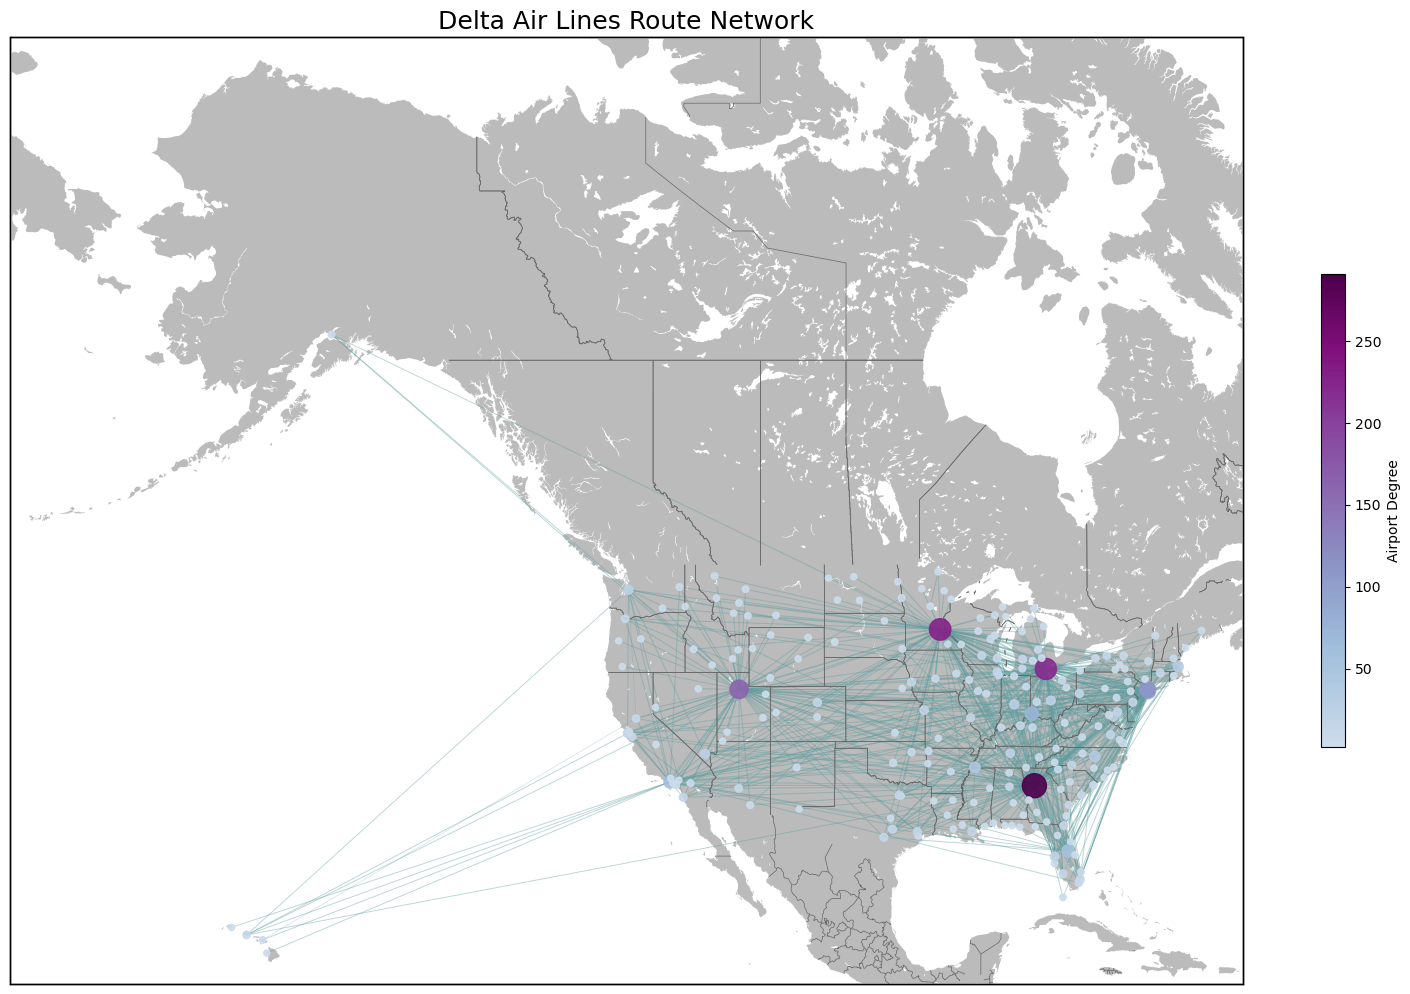

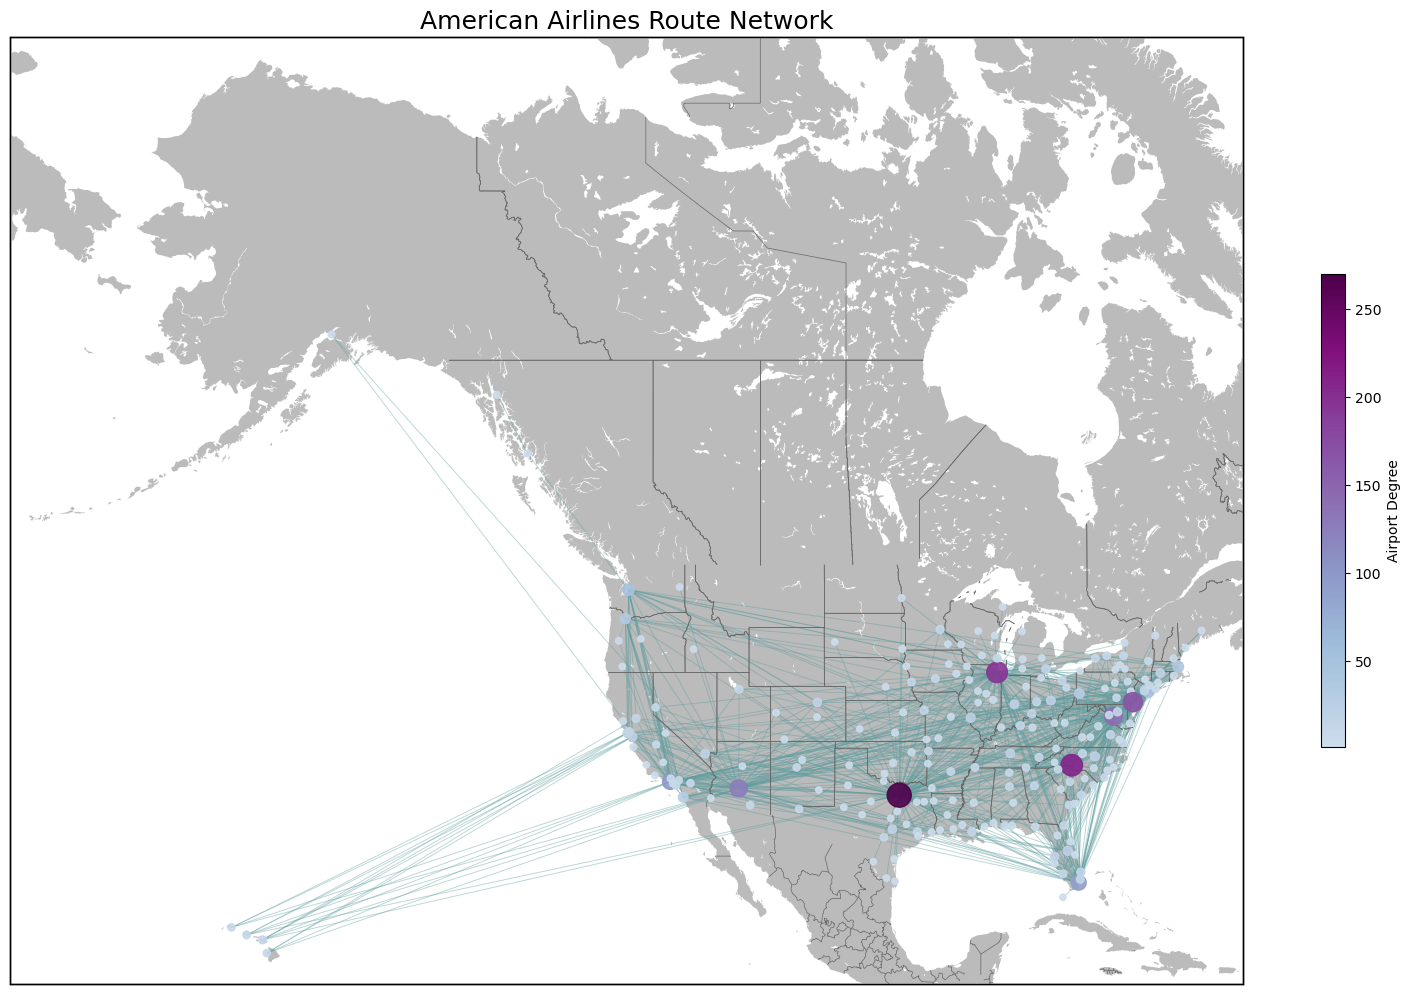

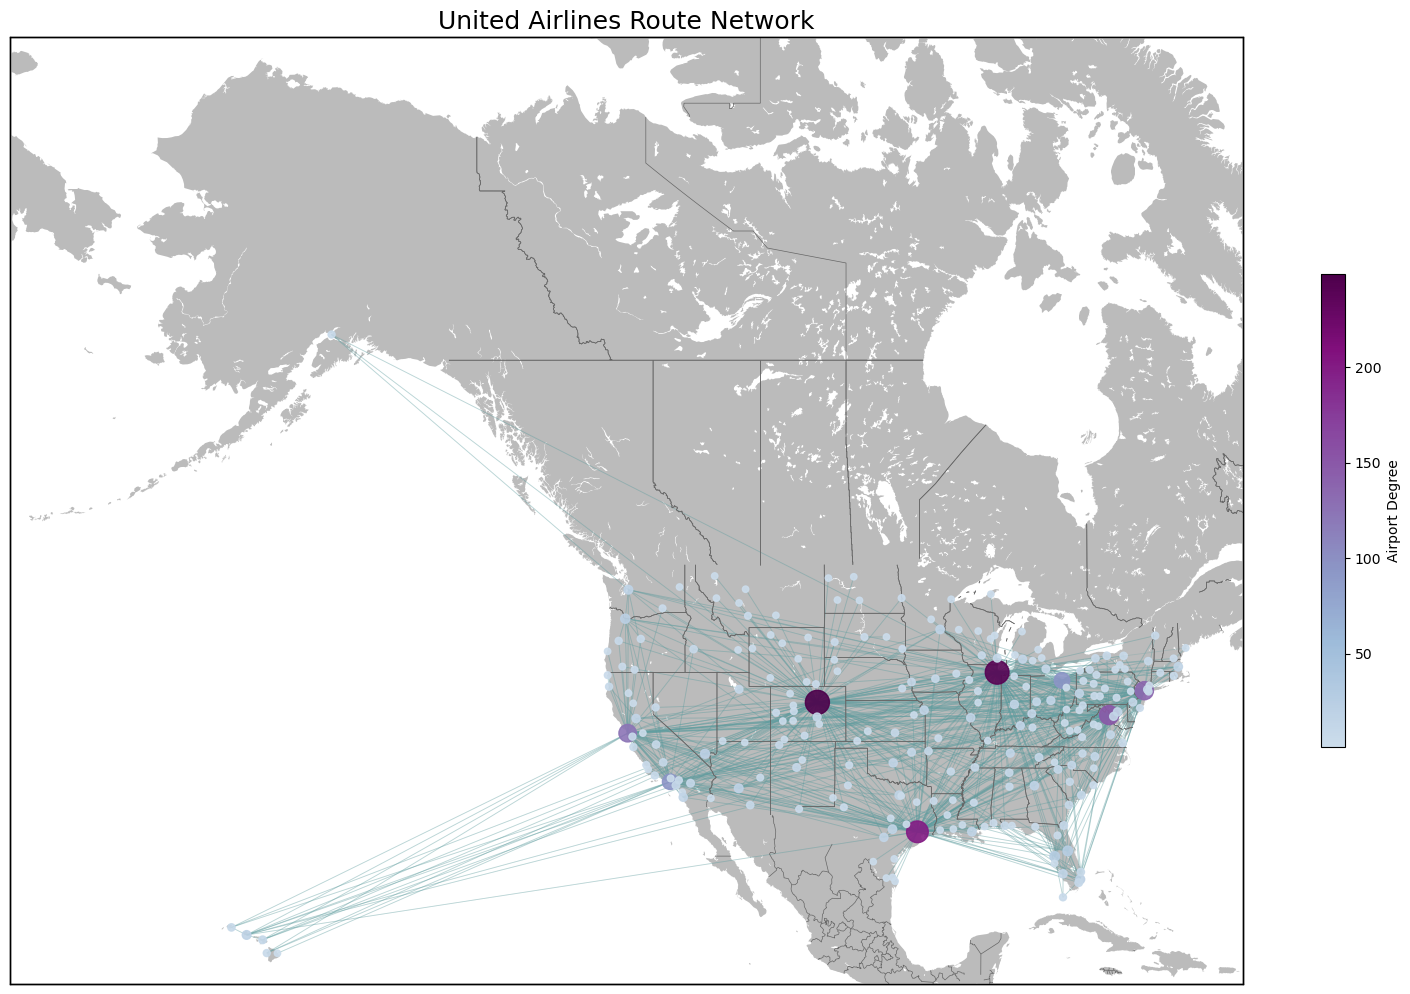

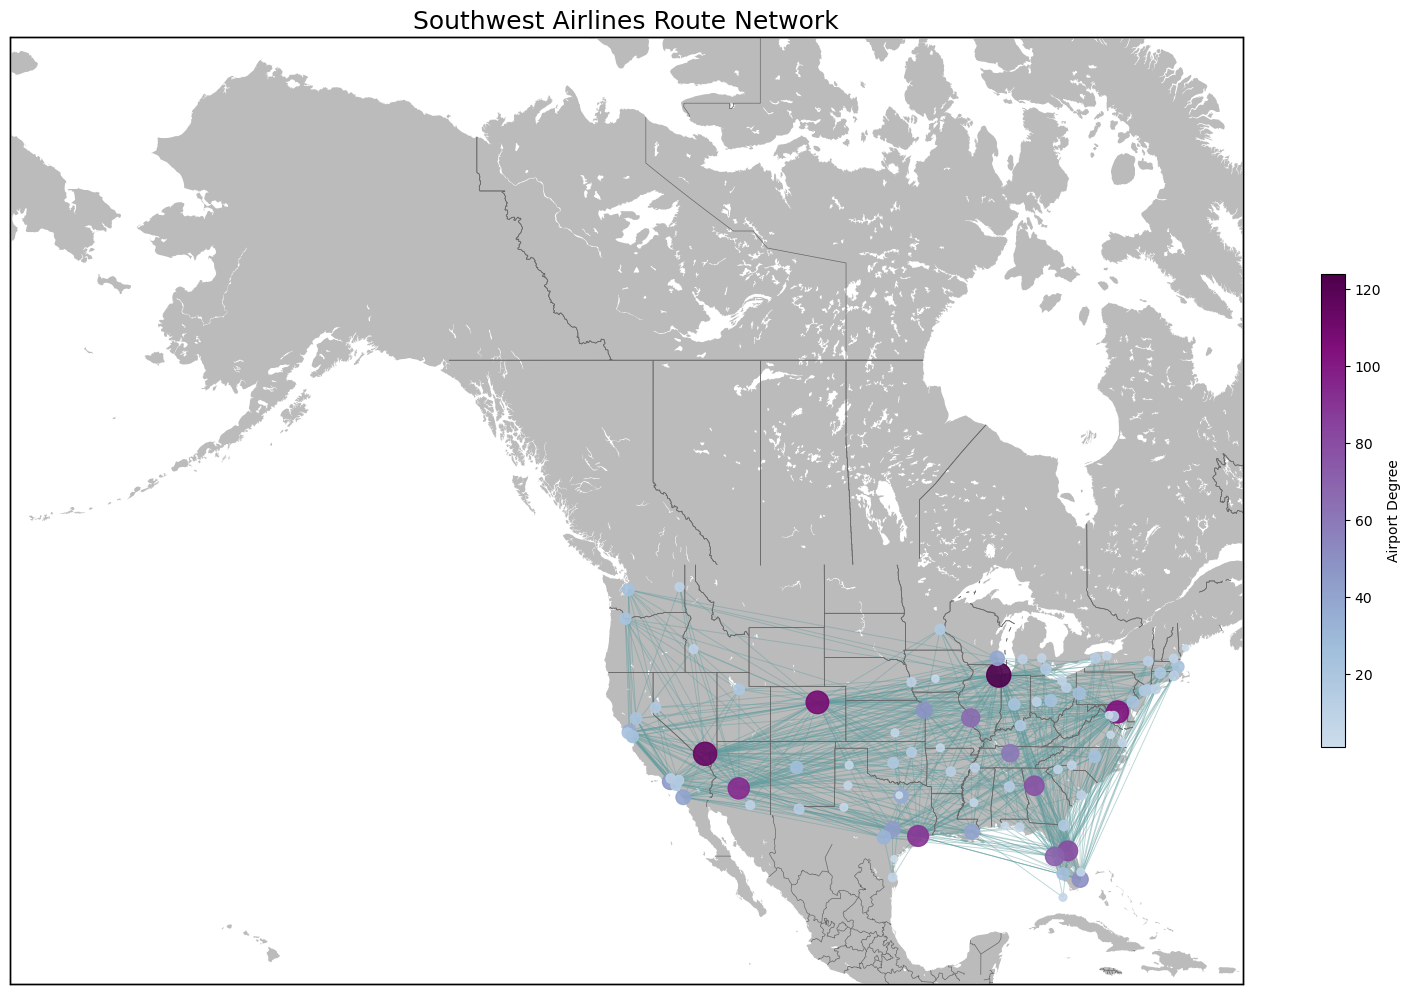

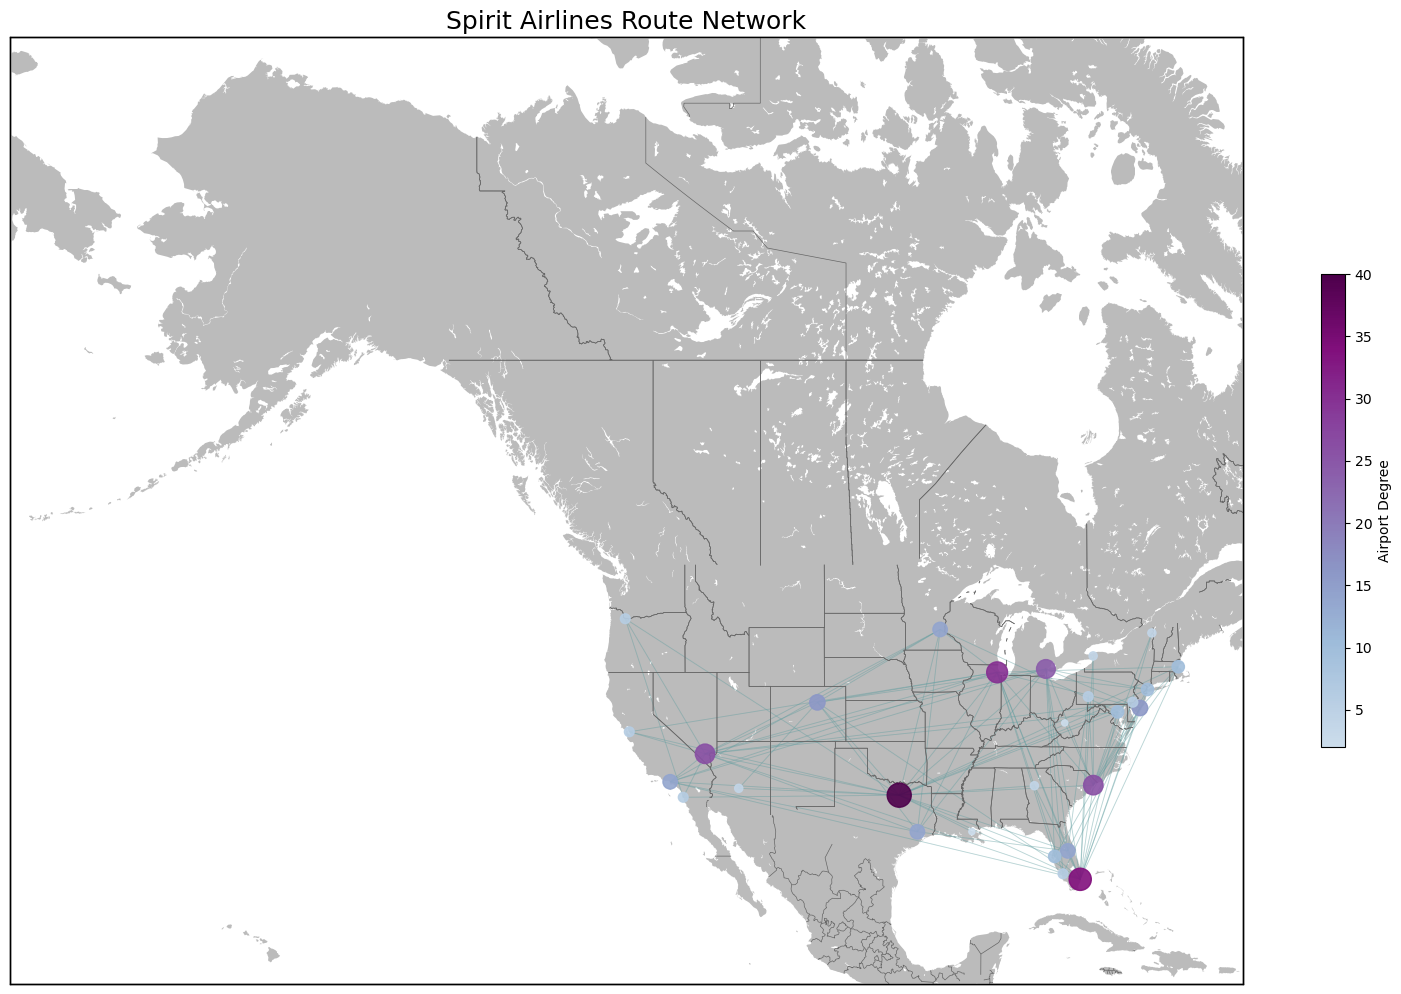

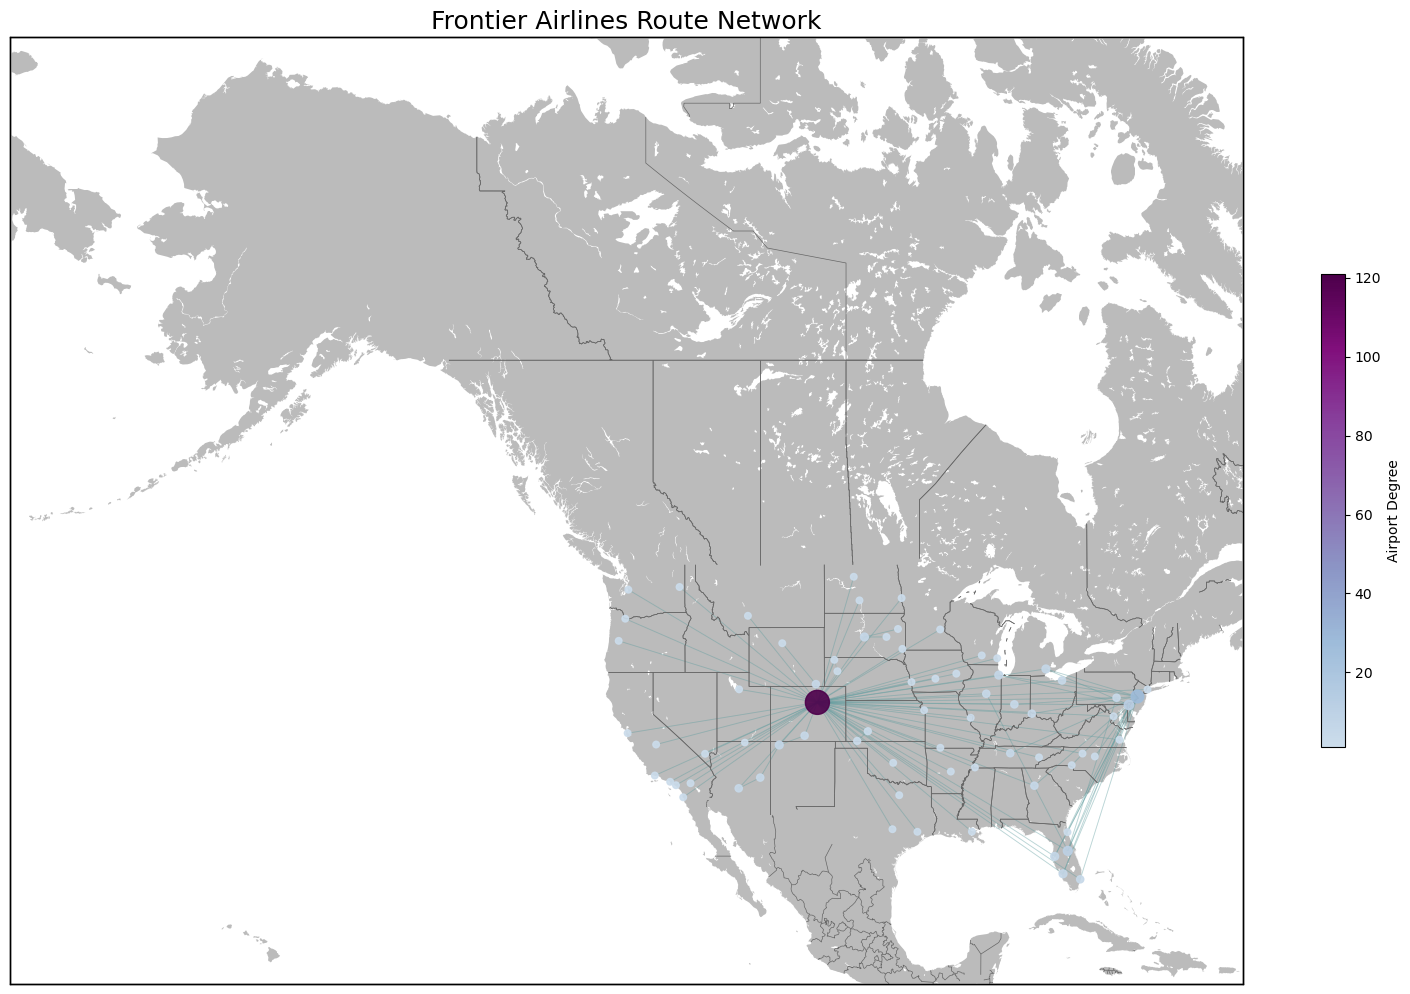

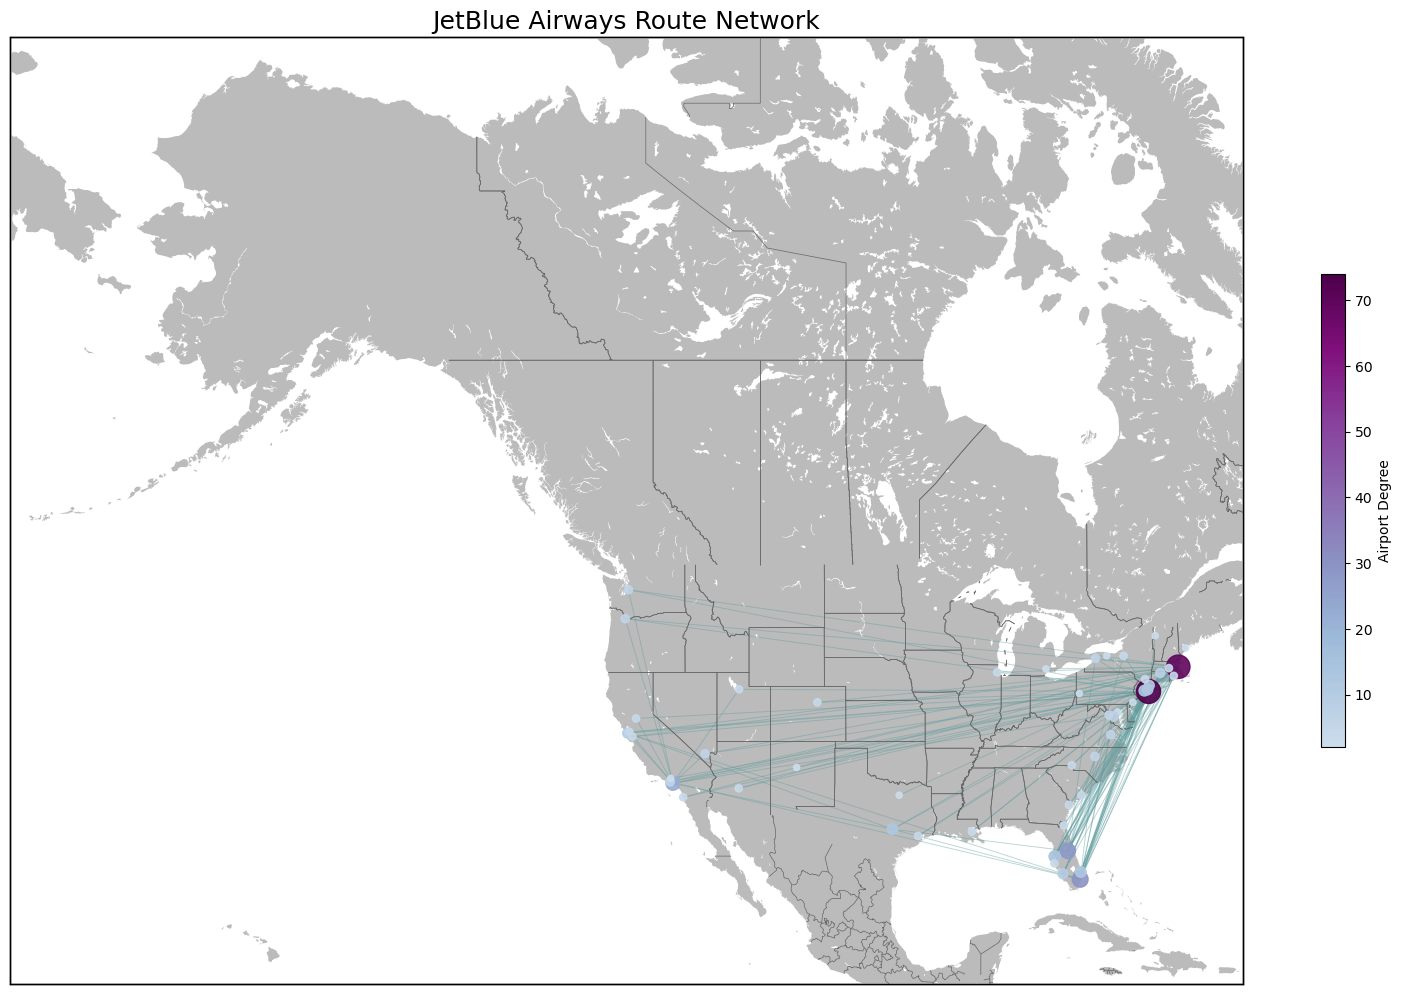

In [8]:
for airline, G in airline_graphs.items():
    plot_airline_network_styled(G, f"{airline} Route Network", airport_coords)

In [9]:
import numpy as np
import networkx as nx
from collections import defaultdict

def compute_airline_centrality_metrics(airline_graphs, k_list=[1, 2, 3]):
    results = []

    for airline, G in airline_graphs.items():
        degrees = dict(G.out_degree())
        total_edges = sum(degrees.values())

        # 1. Degree Centrality
        degree_centrality = nx.out_degree_centrality(G)

        # 2. Gini Coefficient of Out-Degree
        deg_values = np.array(list(degrees.values()))
        if len(deg_values) == 0:
            gini = 0
        else:
            sorted_vals = np.sort(deg_values)
            n = len(sorted_vals)
            cum_vals = np.cumsum(sorted_vals)
            gini = (2 * np.sum((np.arange(1, n+1)) * sorted_vals) / (n * np.sum(sorted_vals))) - (n + 1) / n

        # 3. Top-k Node Share
        top_k_shares = {}
        sorted_deg = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
        for k in k_list:
            top_k_total = sum([d for _, d in sorted_deg[:k]])
            share = top_k_total / total_edges if total_edges > 0 else 0
            top_k_shares[f"Top_{k}_share"] = share

        # 4. Betweenness Centrality
        bc = nx.betweenness_centrality(G, normalized=True)
        top_bc = sorted(bc.items(), key=lambda x: x[1], reverse=True)[:3]

        results.append({
            "Airline": airline,
            "Num_Airports": G.number_of_nodes(),
            "Num_Routes": G.number_of_edges(),
            "Gini_OutDegree": round(gini, 3),
            "Top_1_share": round(top_k_shares["Top_1_share"], 3),
            "Top_2_share": round(top_k_shares["Top_2_share"], 3),
            "Top_3_share": round(top_k_shares["Top_3_share"], 3),
            "Top_Betweenness": top_bc
        })

    return pd.DataFrame(results)


In [10]:
centrality_df = compute_airline_centrality_metrics(airline_graphs)
# Make a clean copy
df_clean = centrality_df.copy()

# Expand Top_Betweenness tuples into readable text
def format_top_bc(bc_list):
    return ", ".join([f"{node} ({score:.2f})" for node, score in bc_list])

df_clean["Top_Betweenness"] = df_clean["Top_Betweenness"].apply(format_top_bc)

# Reorder and round for readability
columns_order = [
    "Airline", "Num_Airports", "Num_Routes",
    "Gini_OutDegree", "Top_1_share", "Top_2_share", "Top_3_share", "Top_Betweenness"
]

df_clean = df_clean[columns_order]
df_clean = df_clean.round(3)

# Display in notebook or print
display(df_clean)  # if you're using Jupyter
# print(df_clean.to_markdown(index=False))  # alternative: clean Markdown table




,Airline,Num_Airports,Num_Routes,Gini_OutDegree,Top_1_share,Top_2_share,Top_3_share,Top_Betweenness
0,Delta Air Lines,217,1327,0.681,0.110,0.196,0.280,"ATL (0.45), MSP (0.26), SLC (0.25)"
1,American Airlines,216,1414,0.678,0.096,0.171,0.240,"DFW (0.41), CLT (0.20), ORD (0.20)"
2,United Airlines,235,1303,0.671,0.094,0.188,0.265,"DEN (0.38), ORD (0.30), IAH (0.21)"
3,Southwest Airlines,89,1126,0.506,0.055,0.106,0.154,"MDW (0.17), LAS (0.13), HOU (0.11)"
4,Spirit Airlines,28,182,0.410,0.110,0.203,0.286,"DFW (0.32), FLL (0.18), MYR (0.16)"
5,Frontier Airlines,72,178,0.534,0.331,0.410,0.444,"DEN (0.91), TTN (0.09), PIR (0.05)"
6,JetBlue Airways,52,238,0.534,0.155,0.303,0.366,"JFK (0.48), BOS (0.40), FLL (0.10)"


Gini score close to 1 → highly centralized (hub-heavy)

Top-k share: how dependent an airline is on a few nodes

Top betweenness airports: shows structural bottlenecks

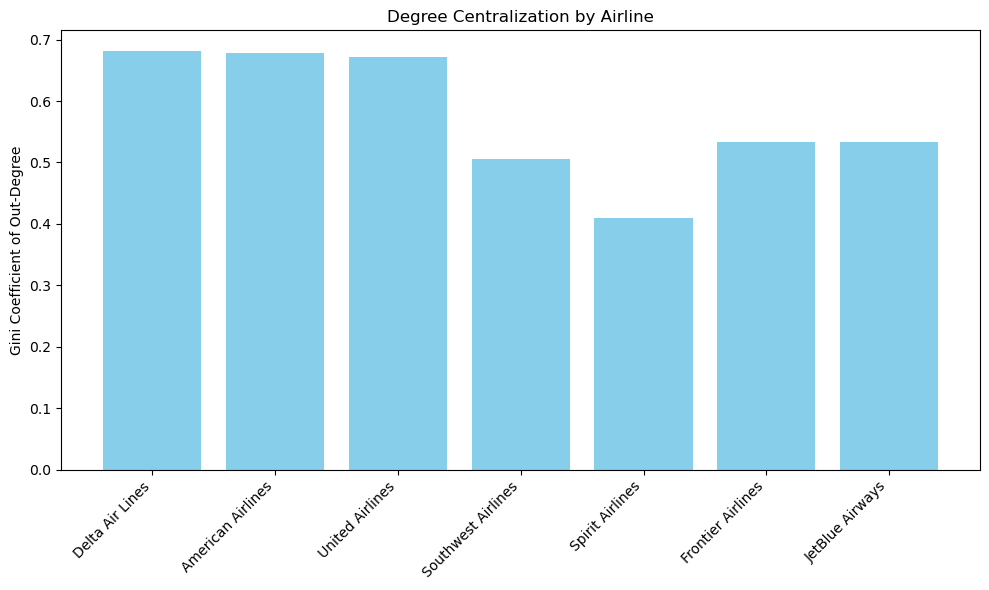

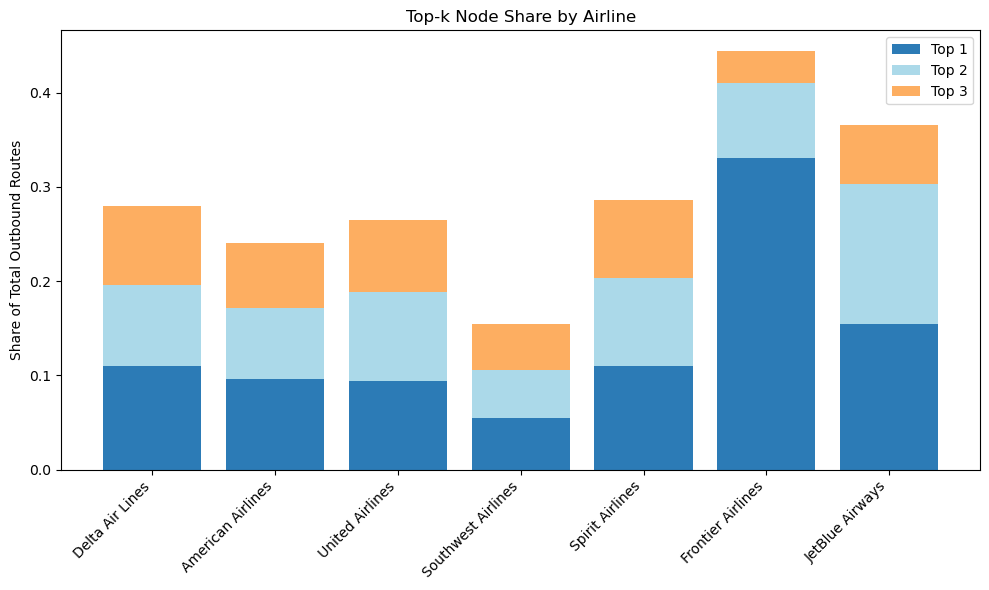

Delta Air Lines:
  ATL: 0.445
  MSP: 0.2605
  SLC: 0.2541

American Airlines:
  DFW: 0.4134
  CLT: 0.2039
  ORD: 0.1965

United Airlines:
  DEN: 0.3809
  ORD: 0.2982
  IAH: 0.2088

Southwest Airlines:
  MDW: 0.1705
  LAS: 0.1333
  HOU: 0.1072

Spirit Airlines:
  DFW: 0.316
  FLL: 0.177
  MYR: 0.1576

Frontier Airlines:
  DEN: 0.914
  TTN: 0.0919
  PIR: 0.0547

JetBlue Airways:
  JFK: 0.4766
  BOS: 0.397
  FLL: 0.0972



In [12]:
import matplotlib.pyplot as plt

def plot_gini_bar_chart(df):
    plt.figure(figsize=(10, 6))
    airlines = df['Airline']
    gini = df['Gini_OutDegree']

    plt.bar(airlines, gini, color='skyblue')
    plt.ylabel('Gini Coefficient of Out-Degree')
    plt.title('Degree Centralization by Airline')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_gini_bar_chart(centrality_df)


def plot_topk_share_stacked(df):
    plt.figure(figsize=(10, 6))
    labels = df['Airline']
    top1 = df['Top_1_share']
    top2 = df['Top_2_share'] - top1
    top3 = df['Top_3_share'] - df['Top_2_share']

    bar1 = plt.bar(labels, top1, label='Top 1', color='#2c7bb6')
    bar2 = plt.bar(labels, top2, bottom=top1, label='Top 2', color='#abd9e9')
    bar3 = plt.bar(labels, top3, bottom=top1 + top2, label='Top 3', color='#fdae61')

    plt.ylabel('Share of Total Outbound Routes')
    plt.title('Top-k Node Share by Airline')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_topk_share_stacked(centrality_df)

for i, row in centrality_df.iterrows():
    print(f"{row['Airline']}:")
    for airport, score in row['Top_Betweenness']:
        print(f"  {airport}: {round(score, 4)}")
    print()


## 5.3 Centrality Analysis

To assess the structural strategies of major U.S. airlines, we analyzed each carrier's flight network using four centrality-based measures:

- **Out-degree centrality** – to detect hubs with high outbound connectivity  
- **Gini coefficient of out-degree** – to quantify network inequality (hub dominance)  
- **Top-k node share** – to measure what percent of flights go through the top 1–3 airports  
- **Betweenness centrality** – to identify critical airports acting as chokepoints  

---

### 🔹 Hub-and-Spoke Carriers: Delta, American, United

Delta, American, and United clearly reflect the **hub-and-spoke model**:

- **High Gini scores** (~0.67–0.68) show strong inequality in node importance.
- **Top-3 node shares** range from 24% to 28%, indicating heavy reliance on a few central airports.
- Dominant hubs like **Atlanta (Delta)**, **Dallas/Fort Worth (American)**, and **Denver (United)** also rank highest in betweenness centrality (≥ 0.38), meaning they lie on a large fraction of shortest paths.

> These findings quantitatively confirm the airlines’ dependence on hub airports. This supports efficient routing but increases vulnerability to hub disruptions.

---

### 🔹 Point-to-Point Carriers: Southwest, Spirit, Frontier

These carriers show **flatter, less centralized networks** – with variation:

- **Southwest**: Lower Gini (0.51) and a Top-1 share of just 5.5%, showing wide route distribution.
- **Spirit**: Gini of 0.41 – the lowest among all airlines – consistent with a dispersed, point-to-point model.
- **Frontier**: Surprisingly **hub-centric**, with **Denver alone accounting for 33%** of outbound routes and a betweenness score of **0.91** – highly centralized for a so-called point-to-point airline.

> While Southwest and Spirit align well with decentralized models, **Frontier reveals hub-like behavior**, suggesting economic or operational trade-offs override pure strategy.

---

### 🔹 Hybrid Carrier: JetBlue Airways

JetBlue demonstrates a **hybrid model**:

- **Moderate Gini (0.53)** and a **Top-3 share of 37%**
- Strong reliance on **JFK and BOS**, which dominate its betweenness centrality profile

> JetBlue combines point-to-point flexibility with regional hub concentration — a balanced, adaptive approach.

---

### 🧠 Key Takeaways

- **Hub-and-spoke carriers** exhibit high centralization, with measurable inequality and network fragility.
- **Point-to-point carriers** are generally more distributed, but **not always purely so** (e.g., Frontier).
- **Betweenness centrality** highlights structural chokepoints — airports that, if disrupted, would heavily impact flow.
- JetBlue and Frontier illustrate how **network structure doesn’t always perfectly align** with business model labels.

---


In [14]:
def simulate_hub_removal(airline_graphs):
    results = []

    for airline, G in airline_graphs.items():
        # Find the hub: highest out-degree node
        degrees = dict(G.out_degree())
        if not degrees:
            continue
        hub = max(degrees, key=degrees.get)

        # Remove the hub
        G_removed = G.copy()
        G_removed.remove_node(hub)

        # Measure impact
        num_components = nx.number_weakly_connected_components(G_removed)
        largest_component_size = max(len(c) for c in nx.weakly_connected_components(G_removed))
        percent_remaining = largest_component_size / G.number_of_nodes()

        results.append({
            "Airline": airline,
            "Top_Hub": hub,
            "Original_Nodes": G.number_of_nodes(),
            "After_Removal_Nodes": G_removed.number_of_nodes(),
            "Num_Components": num_components,
            "Largest_Component_Size": largest_component_size,
            "Percent_Remaining": round(percent_remaining, 3)
        })

    return pd.DataFrame(results)

hub_removal_df = simulate_hub_removal(airline_graphs)
from IPython.display import display

display(hub_removal_df)

#A low Percent_Remaining (e.g., 0.4) = very hub-dependent network (fragile).
#A high value (e.g., 0.9) = resilient, distributed connectivity.



,Airline,Top_Hub,Original_Nodes,After_Removal_Nodes,Num_Components,Largest_Component_Size,Percent_Remaining
0,Delta Air Lines,ATL,217,216,35,182,0.839
1,American Airlines,DFW,216,215,33,183,0.847
2,United Airlines,DEN,235,234,31,200,0.851
3,Southwest Airlines,MDW,89,88,1,88,0.989
4,Spirit Airlines,DFW,28,27,2,26,0.929
5,Frontier Airlines,DEN,72,71,46,18,0.250
6,JetBlue Airways,JFK,52,51,6,46,0.885


In [15]:
def compute_core_clustering(airline_graphs):
    results = []

    for airline, G in airline_graphs.items():
        if G.number_of_nodes() == 0:
            continue

        # K-core analysis
        core_numbers = nx.core_number(G)
        max_k = max(core_numbers.values())

        # Clustering (undirected version only)
        clustering = nx.average_clustering(G.to_undirected())

        results.append({
            "Airline": airline,
            "Max_k_core": max_k,
            "Avg_Clustering": round(clustering, 3)
        })

    return pd.DataFrame(results)

core_df = compute_core_clustering(airline_graphs)

from IPython.display import display

display(core_df)

,Airline,Max_k_core,Avg_Clustering
0,Delta Air Lines,20,0.572
1,American Airlines,22,0.587
2,United Airlines,16,0.570
3,Southwest Airlines,26,0.698
4,Spirit Airlines,12,0.648
5,Frontier Airlines,6,0.129
6,JetBlue Airways,10,0.506


## 5.4 Robustness and Core Structure Analysis

To evaluate the **structural resilience** of airline networks, we analyzed how each airline responds to the **removal of its top hub airport**. We also examined the **internal cohesion** of each network using **k-core decomposition** and **clustering coefficients**.

Unsurprisingly, **hub-and-spoke airlines** (Delta, American, United) exhibit moderate vulnerability to hub failure. After removing their top hubs — **ATL (Delta)**, **DFW (American)**, and **DEN (United)** — their networks fragmented into **31–35 weakly connected components**, but each retained a **strong core**, with the largest component still containing **~84–85%** of the original nodes. This shows that while these networks are highly centralized, they maintain enough redundant routes to prevent catastrophic failure.

**Southwest Airlines**, by contrast, was extremely robust. Removing its top hub, **Chicago Midway (MDW)**, caused **no real fragmentation** — the network remained nearly fully connected, retaining **99% of its airports**. This supports the claim that Southwest's **point-to-point model** offers greater structural resilience, with no single point of failure.

**Spirit Airlines** also performed well, maintaining **93% of its nodes** after removing **DFW**. However, its small network size (28 airports) and moderate clustering suggest that some regional dependencies still exist. In contrast, **Frontier Airlines** was the most fragile: removing **DEN** broke the network into **46 separate components**, with the largest retaining only **25%** of the original nodes. This confirms Frontier's **quasi-hub dependence**, despite its nominal point-to-point business model.

**JetBlue Airways** also showed respectable robustness. Removing **JFK**, its top hub, left the network **88.5% intact**, with only 6 components forming — suggesting a **hybrid structure** with moderate centralization and fallback routes.

Looking at **core structure**, we find that Southwest again stands out with the **deepest k-core (26)** and **highest average clustering (0.698)**. This suggests not only resilience but **strong local connectivity** — airports tend to form highly interconnected clusters. Hub-and-spoke carriers like American and Delta also show high clustering and respectable k-core values (20–22), reflecting dense local cores around hubs.

Spirit and JetBlue exhibit **mid-tier cohesion**, while Frontier ranks lowest in both metrics: a **maximum k-core of just 6** and a **very low clustering coefficient (0.129)**, revealing that its network is sparsely connected and highly dependent on a central node.

> Overall, these results confirm the **robustness advantage of point-to-point networks** like Southwest, while also exposing **hidden fragility in some carriers (like Frontier)** that operate hub-centric networks under a point-to-point label. Hybrid carriers like JetBlue balance centralization with redundancy, and the hub-and-spoke giants show structured resilience — not immune to disruption, but not brittle either.
